In [9]:
import sys
import pandas as pd
import seaborn as sns
sns.set();
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
# from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
# from isolation_forest import *
from sisään_uloskäynnit import *
from reittien_erottelu import *

### Haetaan data, ja siivotaan se

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 2549
uniques in y 2778
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 1
------------------------------
Outliers

Data with outliers:  10000
Ouliers removed:     152
Data after:  9848


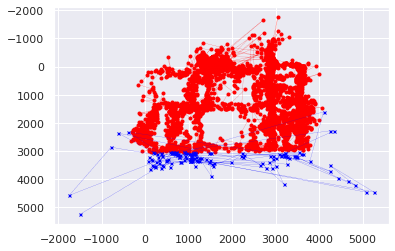

In [10]:
df = database_query("SELECT * FROM SensorData limit 10000")
df = find_outliers(df)
df = clean_dataframe(df)

### Muokataan data grid-muotoon

In [11]:
### Määritellään gridin koko
grid_size = 50

df = xy_to_grid(df,df["x"], df["y"], grid_size)
df

,index,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,0,1,2020-06-24 15:20:08.533,2762,-257,34,15,784
1,1,1,2020-06-24 15:20:08.620,2870,-344,35,14,735
2,2,1,2020-06-24 15:20:09.623,2916,-344,36,14,736
3,3,1,2020-06-24 15:20:09.623,2894,-254,35,15,785
4,4,1,2020-06-24 15:20:10.116,2888,-188,35,16,835
...,...,...,...,...,...,...,...,...
9623,9995,1,2020-06-29 13:19:16.418,1301,-120,18,16,818
9624,9996,1,2020-06-29 13:19:25.418,1301,-119,18,16,818
9625,9997,1,2020-06-29 13:19:35.418,1305,-112,18,16,818
9626,9998,1,2020-06-29 13:19:45.418,1305,-112,18,16,818


### Haetaan Kassojen ja sisäänkäynnin sijainnit ja muokataan ne ID-muotoon

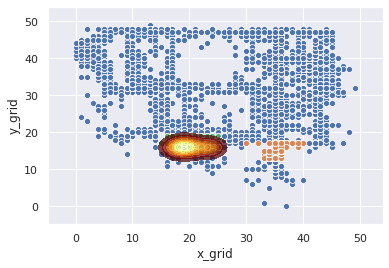

In [12]:
# Haetaan sisäänkäynnin ja kassojen sijainnit grid-arvoina
in_x, in_y = sisään(df, grid_size)
out_x, out_y = ulos(df, grid_size)

# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# Voidaan tarkistaa sijaintien oikeellisuus
sns.scatterplot(x="x_grid", y="y_grid", data = df)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df.x_grid, df.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)
plt.show()

### Erotetaan kauppareissut toisistaan

In [13]:
# Haetaan uniikit id:t
in_ID = in_ID.unique()
out_ID = out_ID.unique()

reitit = erottele_reitit(df, in_ID, out_ID)

reitit = poista_lyhyet_reitit(reitit, 50)
df_reitit = reitit_dataframeksi(reitit)

In [14]:
df_reitit

,ajokerta,timestamp,node_id,ID,x,y
0,1,2020-06-24 15:20:08.620,1,735,35,14
1,1,2020-06-24 15:20:09.623,1,736,36,14
2,1,2020-06-24 15:20:09.623,1,785,35,15
3,1,2020-06-24 15:20:10.116,1,835,35,16
4,1,2020-06-24 15:20:11.086,1,836,36,16
...,...,...,...,...,...,...
3827,13,2020-06-29 12:27:12.418,1,1170,20,23
3828,13,2020-06-29 12:27:17.418,1,1120,20,22
3829,13,2020-06-29 12:27:18.418,1,1069,19,21
3830,13,2020-06-29 12:27:20.418,1,1019,19,20


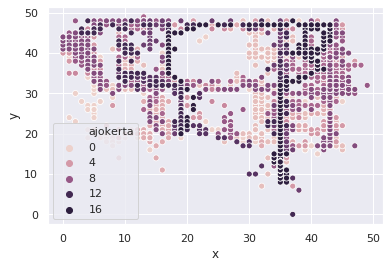

In [15]:
# Plotataan kaikki erotellut kauppareissut yhdessä

plot_all_routes(df_reitit, grid_size)

435


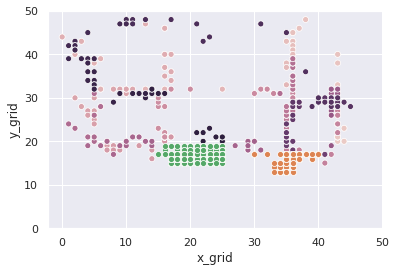

573


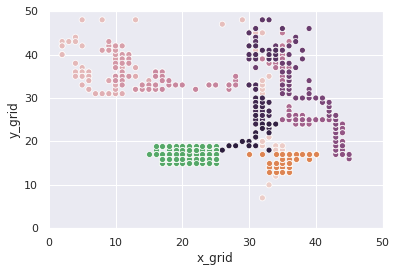

376


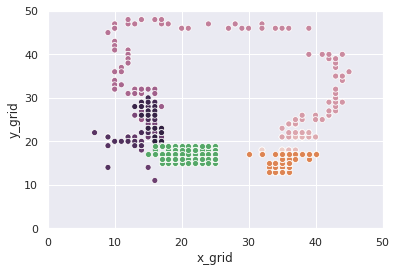

348


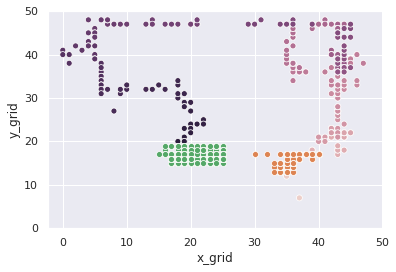

191


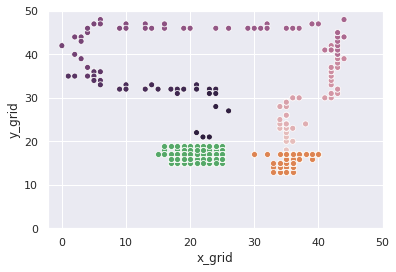

425


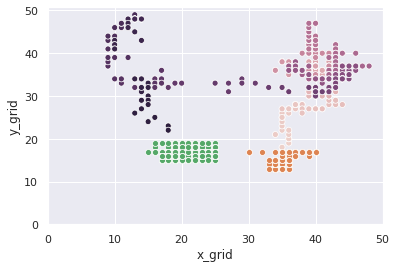

267


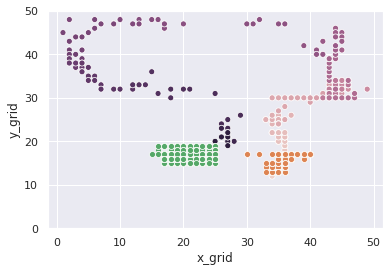

378


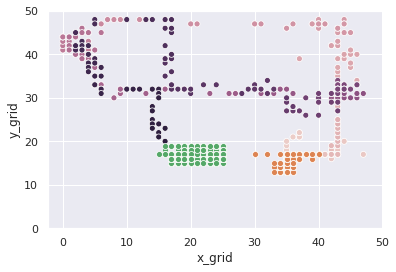

146


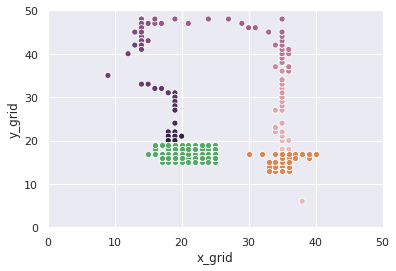

70


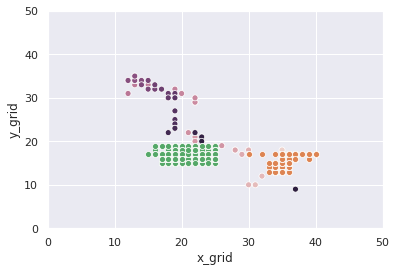

196


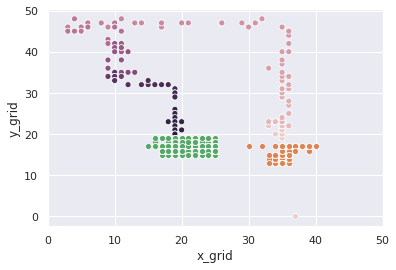

427


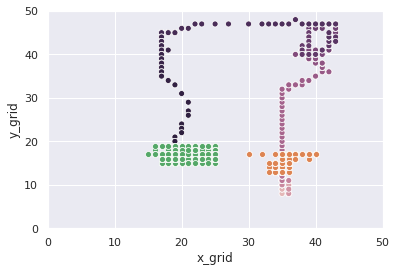

In [16]:
# Plottaa jokaisen kauppareissut erikseen.

plot_unique_routes(df_reitit, grid_size, in_x, in_y, out_x, out_y)   
# Ensimmäisissä on aika paljon häiriötä